instead of selecting a country, I used all countries inorder to creat a model which can predict how many people from all countries are going to be vaccinated in future 

## Importing the libraries

In [6]:
import pandas as pd
import datetime
import seaborn as sns

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
%matplotlib inline

import missingno
import sklearn

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Load and Prepare Data

In [7]:
df = pd.read_csv("C:/Users/98913/Desktop/folders/ML/PROJECT/16266142175124433/Project 1 - Covid Vaccination/country_vaccinations.csv")
df2 = pd.read_csv("C:/Users/98913/Desktop/folders/ML/PROJECT/16266142175124433/Project 1 - Covid Vaccination/country_vaccinations_by_manufacturer.csv")

## EDA

In [8]:
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


### missing values

In [9]:
df.isnull().sum()

country                                    0
iso_code                                   0
date                                       0
total_vaccinations                     13789
people_vaccinated                      14686
people_fully_vaccinated                17445
daily_vaccinations_raw                 16819
daily_vaccinations                       292
total_vaccinations_per_hundred         13789
people_vaccinated_per_hundred          14686
people_fully_vaccinated_per_hundred    17445
daily_vaccinations_per_million           292
vaccines                                   0
source_name                                0
source_website                             0
dtype: int64

we can see the missing vlaues using a matrix

<AxesSubplot:>

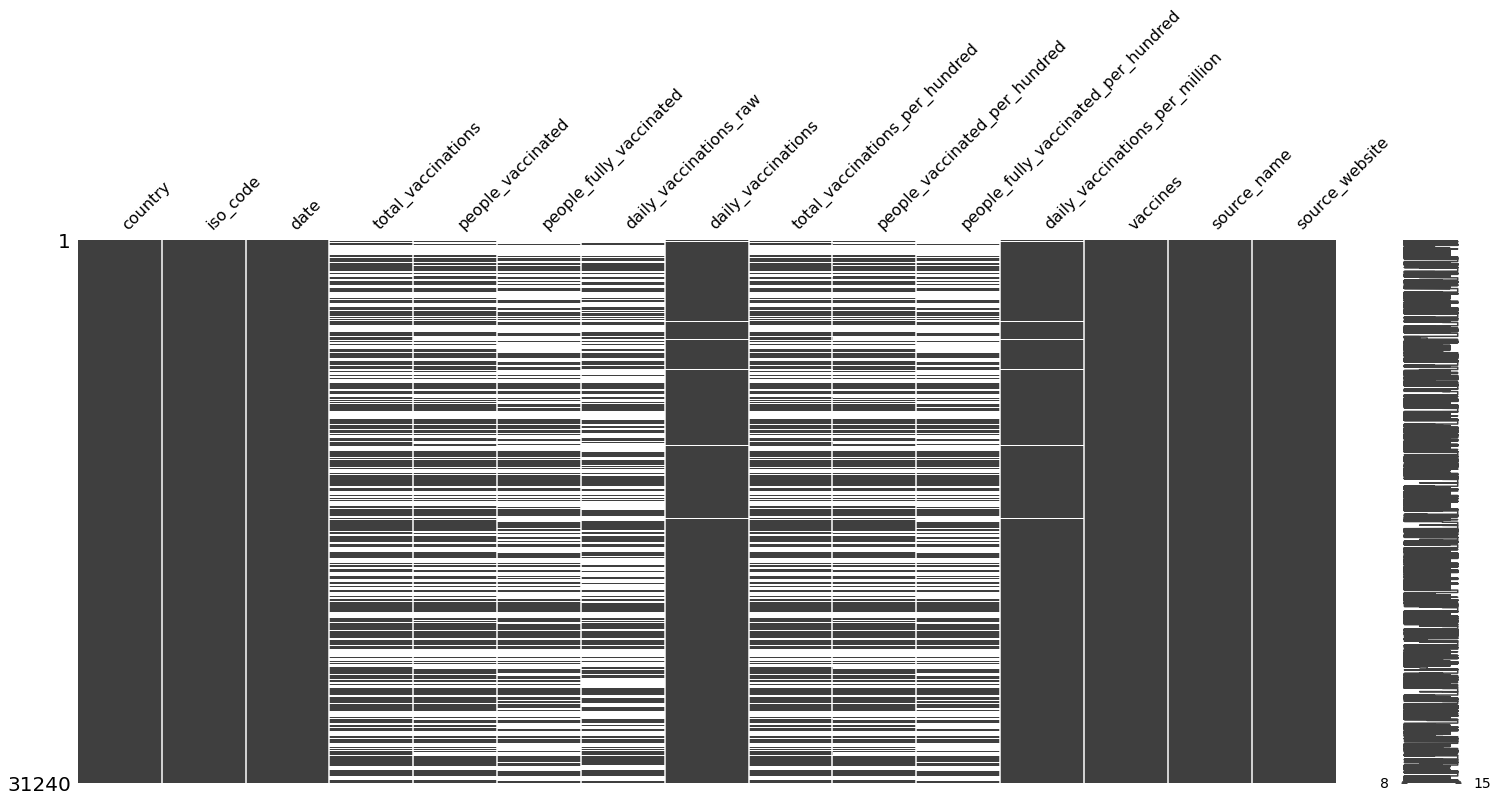

In [10]:
missingno.matrix(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31240 entries, 0 to 31239
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              31240 non-null  object 
 1   iso_code                             31240 non-null  object 
 2   date                                 31240 non-null  object 
 3   total_vaccinations                   17451 non-null  float64
 4   people_vaccinated                    16554 non-null  float64
 5   people_fully_vaccinated              13795 non-null  float64
 6   daily_vaccinations_raw               14421 non-null  float64
 7   daily_vaccinations                   30948 non-null  float64
 8   total_vaccinations_per_hundred       17451 non-null  float64
 9   people_vaccinated_per_hundred        16554 non-null  float64
 10  people_fully_vaccinated_per_hundred  13795 non-null  float64
 11  daily_vaccinations_per_milli

In [16]:
corr = df.corr()

Text(0.5, 1.0, 'Correlation Between different Features')

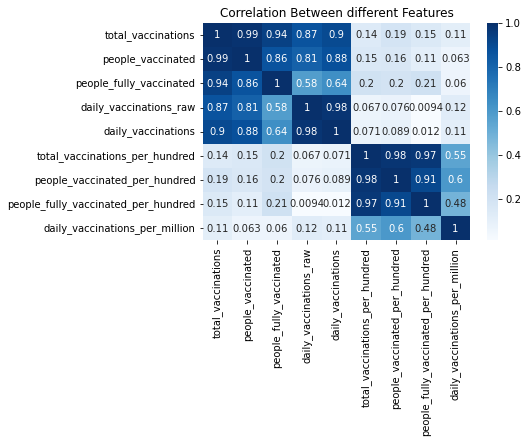

In [17]:
sns.heatmap(corr,annot=True,cmap="Blues")
plt.title('Correlation Between different Features')

there are so many related features which are redundant. 
we are  going to use only "daily_vaccinations" , date and "total_vaccinations" features

## Data Preprocessing

In [18]:
df['date'] = df['date'].str.replace('-','')

In [19]:
df["daily_vaccinations"] = df["daily_vaccinations"].fillna(0) 

In [20]:
daily_vac = df.groupby(["date"]).sum()

In [21]:
daily_vac['Cumulative Frequency'] = daily_vac['daily_vaccinations'].cumsum()

In [22]:
daily_vac["date_1"] = sorted(list(set(df["date"])))

In [23]:
daily_vac['Month'] = pd.DatetimeIndex(daily_vac['date_1']).month
daily_vac['Year'] = pd.DatetimeIndex(daily_vac['date_1']).year
daily_vac['day'] = pd.DatetimeIndex(daily_vac['date_1']).day

In [24]:
daily_vac.head(20)

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,Cumulative Frequency,date_1,Month,Year,day
date,,,,,,,,,,,,,,
20201202,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,20201202,12,2020,2
20201203,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,20201203,12,2020,3
20201204,1.0,1.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,20201204,12,2020,4
20201205,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,20201205,12,2020,5
20201206,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,20201206,12,2020,6
20201207,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,20201207,12,2020,7
20201208,7207.0,7207.0,0.0,0.0,0.0,0.04,0.04,0.0,0.0,0.0,20201208,12,2020,8
20201209,20653.0,20653.0,0.0,13446.0,13446.0,0.13,0.13,0.0,874.0,13446.0,20201209,12,2020,9
20201210,37426.0,37426.0,0.0,16773.0,15110.0,0.25,0.25,0.0,993.0,28556.0,20201210,12,2020,10


<AxesSubplot:title={'center':'Total No of Vaccination done By country'}, xlabel='location', ylabel='total_vaccinations'>

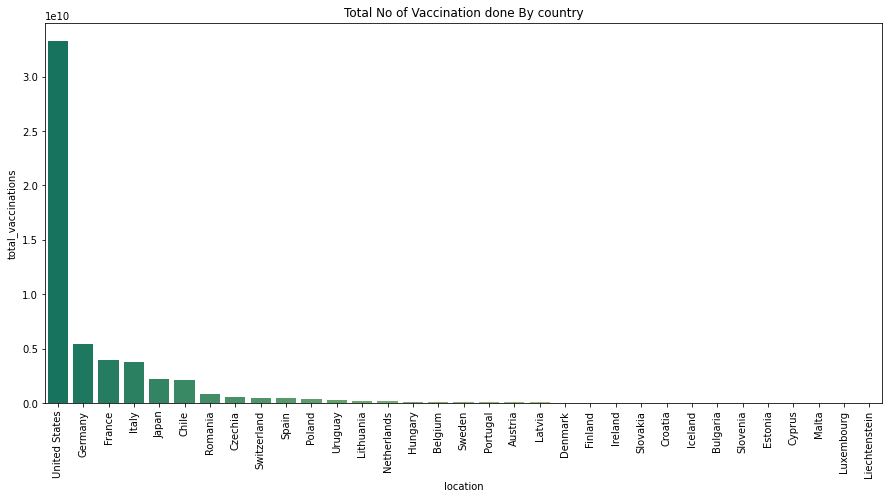

In [25]:
sum_df=df2.groupby('location').sum().sort_values(by='total_vaccinations',ascending=False)
fig,ax=plt.subplots(figsize=(15,7))
plt.title('Total No of Vaccination done By country')
plt.xticks(rotation=90)
sns.barplot(x=sum_df.index,y=sum_df['total_vaccinations'],palette='summer')

<AxesSubplot:title={'center':'Total No of Vaccines manufactured By companies'}, xlabel='vaccine', ylabel='total_vaccinations'>

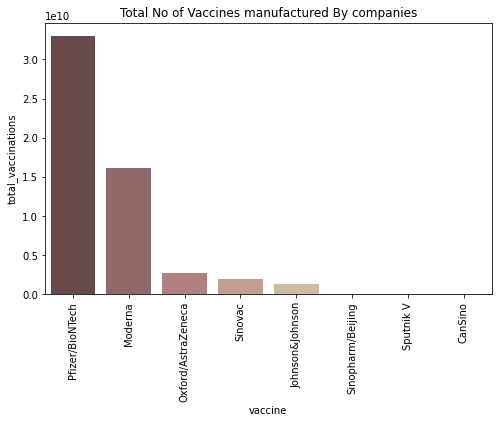

In [26]:
by_company=df2.groupby('vaccine').sum().sort_values(by='total_vaccinations',ascending=False)
fig,ax=plt.subplots(figsize=(8,5))
plt.title('Total No of Vaccines manufactured By companies')
plt.xticks(rotation=90)
sns.barplot(x=by_company.index,y=by_company['total_vaccinations'],palette='pink')

## Strorytelling - Visualization

<AxesSubplot:xlabel='date', ylabel='Cumulative Frequency'>

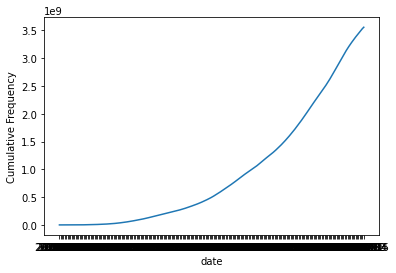

In [27]:
sns.lineplot(x="date", y="Cumulative Frequency", data=daily_vac)

<AxesSubplot:xlabel='date', ylabel='daily_vaccinations'>

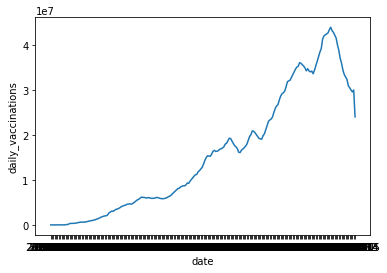

In [28]:
sns.lineplot(x="date", y="daily_vaccinations", data=daily_vac)

<AxesSubplot:xlabel='date', ylabel='total_vaccinations'>

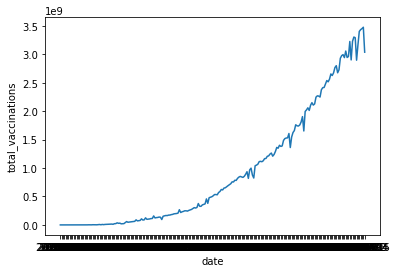

In [29]:
sns.lineplot(x="date", y="total_vaccinations", data=daily_vac)

## Prepare Data for Machine learning

In [30]:
daily_vac

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,Cumulative Frequency,date_1,Month,Year,day
date,,,,,,,,,,,,,,
20201202,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000e+00,20201202,12,2020,2
20201203,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000e+00,20201203,12,2020,3
20201204,1.000000e+00,1.000000e+00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000e+00,20201204,12,2020,4
20201205,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000e+00,20201205,12,2020,5
20201206,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000e+00,20201206,12,2020,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210711,3.403225e+09,1.314681e+09,726297003.0,17923668.0,30542296.0,5921.13,3558.01,2472.21,701380.0,3.444419e+09,20210711,7,2021,11
20210712,3.434948e+09,1.337957e+09,734094748.0,25389933.0,30046106.0,7083.02,4091.70,2788.17,693653.0,3.474465e+09,20210712,7,2021,12
20210713,3.453160e+09,1.329449e+09,732933062.0,31089973.0,29602347.0,7482.36,4295.08,2972.41,659311.0,3.504067e+09,20210713,7,2021,13


In [31]:
X = daily_vac.loc[:,['Month', 'Year' , 'day']].values
y = daily_vac.loc[:,'daily_vaccinations'].values
y2 = daily_vac.loc[:,'total_vaccinations'].values

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=42)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(180, 3)
(180,)
(46, 3)
(46,)


In [36]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.08,
    subsample=0.75,
    colsample_bytree=1, 
    max_depth=7,
    gamma=0,
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
scores = cross_val_score(xgb_model, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.99


In [40]:
y_pred  = xgb_model.predict(X_test)

In [41]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 638656.094996


In [42]:
from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(y_test, y_pred))
print("R_Squared Score : %f" % (r2))

R_Squared Score : 0.998875


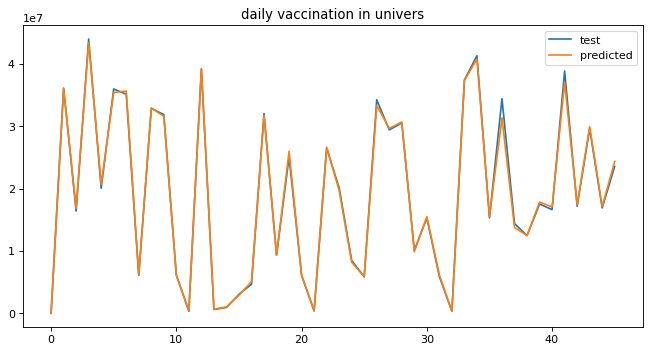

In [43]:
plt.figure(figsize=(10, 5), dpi=80)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="test")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("daily vaccination in univers")
plt.legend()
plt.show()

In [60]:
xgb_model.fit(X_train , y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [61]:
y_pred  = xgb_model.predict(X_test)

In [62]:
from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(y_test2, y_pred))
print("R_Squared Score : %f" % (r2))

R_Squared Score : 0.997693


# Linear Regression

In [64]:
from sklearn.linear_model import LinearRegression
lr_model=LinearRegression()

In [71]:
lr_model.fit(X_train , y_train2)

LinearRegression()

In [72]:
y_pred  = lr_model.predict(X_test)

In [73]:
from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(y_test2, y_pred))
print("R_Squared Score : %f" % (r2))

R_Squared Score : 0.956482
